In [1]:
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from numpy import *
from pylab import *
import math


In [2]:
N = 2
NA = 6
NJ = 100

# Set convergence tolerance and max number of iterations
tol = 1e-3
itmax = 500

In [3]:
#constants for the problem
I = 1.0             # Amp
L = 4.15            # cm
rac = 0.09          # cm
ra =  0.43          # cm
io = 0.06           # Amp/cm^2
ao = 50.0			# cm-1

F = 96487.0         # C/mol
R = 8.314           # J/mol-K
T = 298.0           # K
pi=3.14           
epao = 0.74         # initial anode porosity

alpha = 0.75        # anodic transfer coeff 
kappa = 0.6690      # 1/ohm/cm soltn conductivity 


KOH_o = 0.003       # cm/s OH ions mass transfer coeff
KZnOH_o = 0.001     # cm/s ZnOH ions mass transfer coeff

COH = 0.007         # moles/cm^3
CZnOH = 0.00053     # moles/cm^3

DKZnOH=6.9e-6       # cm^2/s
DKOH = 2.32e-5      # cm^2/s

tOH = 0.74          # transference number
tZnOH = 0.04        # transference number

Keq = 0.0232        # moles/cm^3
kx = 0.005          # cm/s precipitation rate constant


VZn = 9.15          # cm^3/mole 
VZnO = 14.51        # cm^3/mole
VKOH = 17.8         # cm^3/mole 
VZnOH = 67.0        # cm^3/mole
VKZnOH = 67.0       # cm^3/mole
VH2O = 18.07        # cm^3/mole

# Some Cathode properties
# properties of cathode
rs = 0.45           # cm
rc = 0.66           # cm           
epc = 0.26          # cathode porosity 
Vc = 3.14*(rc**2 - ra**2)*L # cathode volume
Acat = 2*3.14*(rc-ra)*L     # cathode area
VMnO2 = 17.29               # cm^3/mole
VMnOOH = 20.45              # cm^3/mole
theta = 0.8                 # extent of reaction constant

#Make the Mesh
xmax = 0.43-0.09
h = xmax/(NJ-1)
rr = np.linspace(rac,ra,NJ)
aio = ao*io

In [4]:
ep_Zn_o = 0.26      # initial Zn volume fraction
ep_ZnO_o  = 0.0     # initial ZnO volume fraction

sigma_Zn = 1.83e5   # /ohm/cm
sigma_ZnO = 0.01    # /ohm/cm

In [5]:
# INTERPOLATE
# ===========
def interpolate( c, h, order ):
 
    ( N, NJ )=c.shape
    
    cE=np.concatenate( (      c[:,1:NJ], np.zeros((N,1)) ), axis=1 )
    cW=np.concatenate( (   np.zeros((N,1)),  c[:,0:NJ-1] ), axis=1 )
 
    dcdx=(cE-cW)/2.0/h;
    dcdx[:, 0  ] = ( - 3.0*c[:, 0  ] + 4.0*c[:,1   ] - c[:,2   ] ) /2.0 /h;
    dcdx[:,NJ-1] = (   3.0*c[:,NJ-1] - 4.0*c[:,NJ-2] + c[:,NJ-3] ) /2.0 /h;
 
    #if ( order >= 2 ):
 
    d2cdx2= (cE + cW - 2*c)/h**2;
    d2cdx2[:,0] = np.zeros((1,N));
    d2cdx2[:,NJ-1] = np.zeros((1,N));
 
    return  dcdx , d2cdx2 


In [6]:
# Transfer Current
# ===========
def transfer(jcold):
    
    # Calculates the tranfer current j
    # Uses the 1st variable in cold, which is i2
    
    jdcdx, jd2cdx2 = interpolate(jcold,h,2)
    trans = jdcdx[0,:] + jcold[0,:]/rr[:]
    if abs(trans[1]) <= 1e-5:
          trans[0] = trans[1]
    trans[NJ-1] = trans[NJ-2]
    return trans

In [7]:
def initguess():
    
    cold = np.ones([N,NJ])
    cold[0,:]=-0.05  # i2
    cold[1,:]=0.01 # eta
    
    return cold

In [8]:
#Steady State Problem
#====================================

# Fillmat Matrix function for i2 and eta 
# =======

def fillmat1(cold,dcdx,d2cdx2):

    sma = zeros([N,NJ,N])
    smb = zeros([N,NJ,N])
    smd = zeros([N,NJ,N])
    smg = zeros([N,NJ])
    
    sigma = 20.0
    
    A1 = (sigma+(epao**1.5)*kappa)/((epao**1.5)*kappa*sigma)
    
    beta = (1-alpha)*2*F/R/T
    betac = -alpha*2*F/R/T

    
    P1 = aio*exp(beta*cold[1,:])
    P2 = aio*exp(betac*cold[1,:])
    
    smb[0,:,0] = 1
    smd[0,:,0] = 1/rr[:]
    smd[0,:,1] = -beta*P1 + betac*P2
    smg[0,:] = P1 - P2 - dcdx[0,:] - cold[0,:]/rr[:]
    
    smd[1,:,0] = -A1
    smb[1,:,1] = 1
    smg[1,:] = -I/(2*pi*rr[:]*L*sigma) + A1*cold[0,:] - dcdx[1,:]
	
	
	# Boundary Condition 1
	
    smp = zeros([N,N])
    sme = zeros([N,N])
    smf = zeros([N,1])
	
	#BC 1 r=rac, i2=0
    sme[0,0] = 1
    smf[0] = -cold[0,0]
	
	
	#Non BC's
    smp[1,1] = 1
    sme[1,0] = -A1
    smf[1] = -I/(2*pi*rr[0]*L*sigma) + A1*cold[0,0] - dcdx[1,0]
    
    smb[:,0,:] = smp[:,:]
    smd[:,0,:] = sme[:,:]
    smg[:,0] = transpose(smf)
    
	#____Boundary Condition 2
	
    smp = zeros([N,N])
    sme = zeros([N,N])
    smf = zeros([N,1])
	
	#BC 2 at r=ra, i2 = I/(2pirL)
    sme[0,0] = 1
    smf[0] = I/(2*pi*ra*L) - cold[0,NJ-1]
	
	#Non BC's
    smp[1,1] = 1
    sme[1,0] = -A1
    smf[1] = -I/(2*pi*rr[NJ-1]*L*sigma) + A1*cold[0,NJ-1] - dcdx[1,NJ-1]
		
    smb[:,NJ-1,:] = smp[:,:]
    smd[:,NJ-1,:] = sme[:,:]
    smg[:,NJ-1] = transpose(smf)
	
    return sma, smb, smd, smg

In [9]:
def abdgxy(sma, smb, smd, smg):
    
    sma = transpose(sma, (0, 2, 1))
    smb = transpose(smb, (0, 2, 1))
    smd = transpose(smd, (0, 2, 1))

    A = sma-h/2.0*smb
    B = -2.0*sma+h**2*smd
    D = sma+h/2.0*smb
    G = h**2*smg

    B[:,:,0] = h*smd[:,:,0]-1.5*smb[:,:,0]
    D[:,:,0] = 2.0*smb[:,:,0]
    G[:,0]=h*smg[:,0]
    X = -0.5*smb[:,:,0]

    A[:,:,NJ-1]=-2.0*smb[:,:,NJ-1]
    B[:,:,NJ-1]=h*smd[:,:,NJ-1]+1.5*smb[:,:,NJ-1]
    G[:,NJ-1]=h*smg[:,NJ-1]
    Y=0.5*smb[:,:,NJ-1]

    ABD = concatenate((A, B, D), axis=1)
    BC1 = concatenate((B[:,:,0] , D[:,:,0] , X), axis=1)
    BC2 = concatenate((Y , A[:,:,NJ-1] , B[:,:,NJ-1]), axis=1)
    ABD[:,:,0] = BC1
    ABD[:,:,NJ-1] = BC2

    return ABD, G

In [10]:
def band(ABD, G):
    
    BMrow = reshape(arange(1,N*NJ+1), (NJ,N))
    BMrow = BMrow[:, :, newaxis]
    BMrow = transpose(BMrow, (1, 2, 0))
    BMrow = BMrow[:,[0 for i in range(3*N)],:]
    
    a = arange(1,3*N+1)
    a = a[newaxis,:]
    a = repeat(a,N,0)
    a = a[:,:,newaxis]
    a = repeat(a,NJ,2)

    b = arange(0,(N)*(NJ-3)+N,N)
    b = hstack((b[0], b, b[len(b)-1]))
    b = b[newaxis,newaxis,:]
    b = repeat(b,N,0)
    b = repeat(b,3*N,1)
    
    BMcol = a + b
    BMcol = BMcol - 1
    BMrow = BMrow - 1
    BMrow = ravel(BMrow)
    BMcol = ravel(BMcol)
    ABD = ravel(ABD)
    BigMat = coo_matrix((ABD, (BMrow, BMcol)), shape=(N*NJ, N*NJ)).tocsc()
    BigG = transpose(G)
    BigG = ravel(BigG)
    # print BigMat.todense()
    delc = spsolve(BigMat, BigG)
    
    return delc

In [11]:
# MAIN PROGRAM
# ===========

cold = initguess()	

it = 1
did = False 

for it in range(1,itmax):
        
        
    dcdx, d2cdx2 = interpolate(cold,h,2)
    sma, smb, smd, smg = fillmat1(cold,dcdx,d2cdx2)
    ABD, G = abdgxy(sma, smb, smd, smg)
    delc = band(ABD, G)
    delc = delc.reshape((NJ, N))
    delc = transpose(delc)
    maxerror = amax(abs(delc))
    print(it,',',maxerror)
    cold = cold + delc
    if maxerror < tol:
        did = True
        print ('Converged in ' +str(it)+ ' steps.')
        break

if not did:
    print ('The program did not converge.')


1 , 0.13923265272614674
2 , 0.003114580298810513
3 , 9.182488032908424e-05
Converged in 3 steps.


In [12]:
j_1 = transfer(cold)

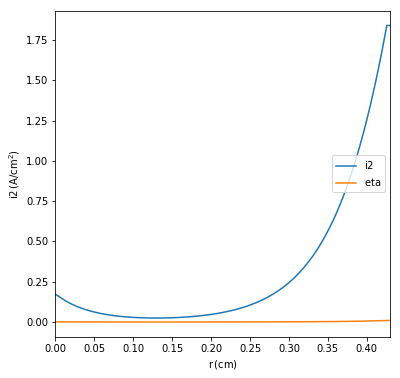

In [13]:
# ===========
# PLOT RESULTS
# ===========

fig,ax = plt.subplots(1,1,figsize=(6, 6))

params = {'mathtext.default': 'regular' }
rcParams.update(params)


xs = linspace(0,ra,NJ)
c1 = j_1
c2 = cold[1,:]
ax.plot(xs,c1)
ax.plot(xs,c2)
ax.legend(['$i2$','$eta$'],loc='center right')
ax.set_ylabel('$i2\/(A/cm^{2})$')
ax.set_xlabel('$r\/(cm)$')
ax.set_xlim(0, ra)
savefig('CD.png', dpi=300)
plt.show()

close('all')


In [14]:
#Time Step
tstep = 10         # sec
total_time = 3200  # sec
total_steps = int(total_time/tstep)

In [15]:
def cathode(catprop,tstep):
        
    # Evolves the cathode properties
    # 0 = cathode porosity
    # 1 = cathode OH- concentration
    # 2 = convection velocity from cathode
    # 3 = OH- conc at anode interface (unchanged here)
    # 4 = overpotential at anode interface (unchanged here) 
    # 5 = OH- flux from anode (unchanged here)
    # 6 = OH- flux to cathode (unchanged here)
    
    
    newcatprop = np.zeros_like(catprop)
    newcatprop[0] = I*(-VMnO2 + 0.1*VMnOOH)*tstep/Vc/F + catprop[0]
    newcatprop[1] = ((Acat*catprop[6] + 0.1*I/F)*tstep/Vc + catprop[0]*catprop[1] )/newcatprop[0]
    newcatprop[2] = -(newcatprop[0]-catprop[0])*Vc/Acat/tstep
    
    if newcatprop[1] <= 0.0:
        newcatprop[1] = 0.0
    
    newcatprop[3] = catprop[3]
    newcatprop[4] = catprop[4]
    newcatprop[5] = catprop[5]
    newcatprop[6] = catprop[6]
    
    return newcatprop

In [16]:
def fluxes(fcold):
    
    dcdr, d2cdr2 = interpolate(fcold,h,2)
    
    cE=np.concatenate((fcold[:,1:NJ], np.zeros((N,1)) ), axis=1 )
    cW=np.concatenate(( np.zeros((N,1)), fcold[:,0:NJ-1] ), axis=1 )
    
    dcdr=(cE-cW)/2.0/h
    dcdr[:,0] = (-3.0*fcold[:,0] + 4.0*fcold[:,1] - fcold[:,2] ) /2.0 /h
    dcdr[:,NJ-1] = (3.0*fcold[:,NJ-1] - 4.0*fcold[:,NJ-2] + fcold[:,NJ-3] ) /2.0 /h
    
    L_flux_OH = -DKOH*dcdr[2,0]*fcold[3,0]**1.5 - tOH/F*fcold[0,0] + fcold[2,0]*fcold[4,0]
    R_flux_OH = -DKOH*dcdr[2,NJ-1]*fcold[3,NJ-1]**1.5 - tOH/F*fcold[0,NJ-1] + fcold[2,NJ-1]*fcold[4,NJ-1]
    
   
    
    return L_flux_OH,R_flux_OH

In [17]:
def properties(Znprop,pcold,tstep):
    

    dcdxpcold, d2cdx2pcold = interpolate(pcold,h,2)
    
    new_prop = np.zeros_like(Znprop)
    
    #aa
    new_prop[0,:] = ao*((1 - pcold[3,:])/(1-epao))**(2/3)
    
    #am
    new_prop[1,:] = new_prop[0,:]*(Znprop[5,:]**(2/3)/(Znprop[5,:]**(2/3) + Znprop[6,:]**(2/3)))
    
   
    for u in new_prop[0,:]:
        for i in new_prop[1,:]:
            if i == u:
                new_prop[2,:] = KOH_o
                new_prop[3,:] = KZnOH_o
                new_prop[4,:] = kx
                
            else:
                #KOH
                new_prop[2,:] = KOH_o/new_prop[0,:]*(new_prop[0,:] - new_prop[1,:])/(np.log(new_prop[0,:]/new_prop[1,:]))
                
                #KZnOH
                new_prop[3,:] = KZnOH_o/new_prop[0,:]*(new_prop[0,:] - new_prop[1,:])/(np.log(new_prop[0,:]/new_prop[1,:]))
                
                #ks
                X = 1/((new_prop[3,:]*new_prop[1,:])/np.log(new_prop[0,:]/(new_prop[0,:] - new_prop[1,:])))
                Y = 1/(((new_prop[0,:]-new_prop[1,:])*kx)/new_prop[0,:])
                Z = X + Y
                new_prop[4,:] = 1/Z
                
               
    "formula for volume fraction change from sunnu paper"
    
    vol_change = np.zeros_like(coldA)
    
    vol_change[0,:] = 1/2/F*(dcdxpcold[0,:] + pcold[0,:]/rr[:])*(VZn + 4*VKOH - VKZnOH - 2*(VKOH*tOH + tZnOH*VKZnOH/2))*tstep
    vol_change[1,:] = new_prop[0,:]*new_prop[4,:]*(pcold[5,:] - pcold[2,:]**2/Keq)*VZnO*tstep
    
    
    new_prop[5,:] = (Znprop[5,:] + vol_change[0,:]) 
    
    
    vg = np.zeros_like(vol_change)
    vg = vol_change[1,:]
    if (vg>0).all() == True:
        new_prop[6,:] = (Znprop[6,:] + vg)
    else:
        new_prop[6,:] = Znprop[6,:]

    #sigma
    new_prop[7,:] = sigma_Zn*(Znprop[5,:]**(1/5)) + sigma_ZnO*Znprop[6,:]**(1/5)
    
    return new_prop
    

In [18]:
def volume_change(vcold,tstep,prop_zinc,init_volume):
    
    dcdxvcold, d2cdx2vcold = interpolate(vcold,h,2)
    new_volume_change = np.zeros_like(vcold)
    
    new_volume_change[0,:] =  1/2/F*(dcdxvcold[0,:] + vcold[0,:]/rr[:])*(VZn + 4*VKOH - VKZnOH - 2*(VKOH*tOH + tZnOH*VKZnOH/2))*tstep
    new_volume_change[1,:] =  -(prop_zinc[0,:]*prop_zinc[4,:]*(vcold[5,:] - vcold[2,:]**2/Keq)*(2*VKOH + VH2O - VKZnOH + VZnO)*tstep)
    
    return new_volume_change

In [19]:
def rate_equation(rcold,tstep,prop_zinc):
    
    rate_equation = np.zeros_like(rcold)
    
    dcdxrcold, d2cdx2rcold = interpolate(rcold,h,2)
    
    # rate equation for OH ions
    rate_equation[0,:] = 2*prop_zinc[0,:]*prop_zinc[4,:]*(rcold[5,:] - rcold[2,:]**2/Keq)
    
    # rate equation for ZnOH ions
    rate_equation[1,:] = -prop_zinc[0,:]*prop_zinc[4,:]*(rcold[5,:] - rcold[2,:]**2/Keq)
    
    rate_equation[2,:] = (2*tOH - 4)/2/F*(dcdxrcold[0,:] + rcold[0,:]/rr[:])
    
    rate_equation[3,:] = (tZnOH + 1)/2/F*(dcdxrcold[0,:] + rcold[0,:]/rr[:])
    
    return rate_equation

In [20]:
# Fillmat Matrix function for i2 and eta 
# =======

def fillmat2(cold,dcdx,d2cdx2,cprev,tstep,catprop,zinc):
    
    ([N,NJ]) = cold.shape
    
    sma = zeros([N,NJ,N])
    smb = zeros([N,NJ,N])
    smd = zeros([N,NJ,N])
    smg = zeros([N,NJ])

    
    
    OHs = catprop[1]
    velo = catprop[2]
     
    aa = zinc[0,:]
    KOH = zinc[2,:]
    KZnOH = zinc[3,:]
    ks = zinc[4,:]
    sigma = zinc[7,:]
    
    C1 = 2*F*aa*KOH
    C2 = 2*F*aa*KZnOH 
    
    beta = (1-alpha)*2*F/R/T
    betac = -alpha*2*F/R/T
    
    B1 = cold[2,:] - dcdx[0,:]/C1 - cold[0,:]/rr[:]/C1
    B2 = cold[5,:] + dcdx[0,:]/C2 + cold[0,:]/rr[:]/C2
    P1 = aa*io*exp(beta*cold[1,:])
    P2 = aa*io*exp(betac*cold[1,:])
    
    
    # Equation for i2
    
    smb[0,:,0] = 1 - 1/(CZnOH)**0.06/(COH)**2.59*(-2.59*(B1)**1.59*(B2)**0.06*(P1)/C1 + 0.06*(B1)**2.59*(B2)**-0.94*(P1)/C2) +\
                1/(CZnOH)**0.94/(COH)**-0.92*(0.94*(B1)**-0.92*(B2)**-0.06*(P2)/C2 + 0.92*(B1)**-1.92*(B2)**0.94*(P2)/C1)
    smd[0,:,0] = 1/rr[:] - 1/(CZnOH)**0.06/(COH)**2.59*(-2.59*(B1)**1.59*(B2)**0.06*(P1)/C1/rr[:] + 0.06*(B1)**2.59*(B2)**-0.94*(P1)/C2/rr[:]) +\
                1/(CZnOH)**0.94/(COH)**-0.92*(0.94*(B1)**-0.92*(B2)**-0.06*(P2)/C2/rr[:] + 0.92*(B1)**-1.92*(B2)**0.94*(P2)/C1/rr[:])
    smd[0,:,1] = -1/(CZnOH)**0.06/(COH)**2.59*((B1)**2.59*(B2)**0.06*beta*(P1)) + 1/(CZnOH)**0.94/(COH)**-0.92*((B1)**-0.92*(B2)**0.94*betac*(P2))
    smd[0,:,2] = - 1/(CZnOH)**0.06/(COH)**2.59*(2.59*(B2)**0.06*(B1)**1.59*(P1)) +\
                1/(CZnOH)**0.94/(COH)**-0.92*(-0.92*(B1)**-1.92*(B2)**0.94*(P2))
    smd[0,:,5] = - 1/(CZnOH)**0.06/(COH)**2.59*(0.06*(B2)**-0.94*(B1)**2.59*(P1)) +\
                1/(CZnOH)**0.94/(COH)**-0.92*(0.94*(B1)**-0.92*(B2)**-0.06*(P2))

    smg[0,:] = (- dcdx[0,:] - cold[0,:]/rr[:])+ 1/(CZnOH)**0.06/(COH)**2.59*((B1)**2.59*(B2)**0.06*(P1)) -\
                1/(CZnOH)**0.94/(COH)**-0.92*((B1)**-0.92*(B2)**0.94*(P2))
    
    
    # Equation for eta
    
    smd[1,:,0] = -1/kappa*cold[5,:]*cold[2,:] - 1/sigma*cold[2,:]*cold[3,:]**1.5*cold[5,:]
    smb[1,:,1] = cold[2,:]*cold[3,:]**1.5*cold[5,:]
    smb[1,:,2] = -2*R*T/F*(2-tOH)*cold[3,:]**1.5*cold[5,:]
    smd[1,:,2] = cold[3,:]**1.5*dcdx[1,:]*cold[5,:] -\
                1/kappa*cold[0,:]*cold[5,:] -\
                1/sigma*cold[3,:]**1.5*cold[0,:]*cold[5,:] +\
                I/(2*pi*rr[:]*L*sigma)*cold[3,:]**1.5*cold[5,:] -\
                3*R*T/F*(-1/2 - tZnOH/2)*cold[3,:]**1.5*dcdx[5,:]
    smd[1,:,3] = 1.5*cold[2,:]*cold[3,:]**0.5*dcdx[1,:]*cold[5,:] -\
                1/sigma*1.5*cold[2,:]*cold[3,:]**0.5*cold[0,:]*cold[5,:] +\
                I/(2*pi*rr[:]*L*sigma)*1.5*cold[2,:]*cold[3,:]**0.5*cold[5,:] -\
                2*R*T/F*(2-tOH)*1.5*cold[3,:]**0.5*dcdx[2,:]*cold[5,:] -\
                3*R*T/F*(-1/2-tZnOH/2)*1.5*cold[3,:]**0.5*cold[2,:]*dcdx[5,:]
    smb[1,:,5] = -3*R*T/F*(-1/2 - tZnOH/2)*cold[3,:]**1.5*cold[2,:]
    smd[1,:,5] = cold[3,:]**1.5*dcdx[1,:]*cold[2,:] -\
                1/kappa*cold[0,:]*cold[2,:] -\
                1/sigma*cold[3,:]**1.5*cold[0,:]*cold[2,:] +\
                I/(2*pi*rr[:]*L*sigma)*cold[3,:]**1.5*cold[2,:] -\
                2*R*T/F*(2 - tOH)*cold[3,:]**1.5*dcdx[2,:]
    
    smg[1,:] =  1/kappa*cold[0,:]*cold[2,:]*cold[5,:] +\
                1/sigma*cold[0,:]*cold[2,:]*cold[3,:]**1.5*cold[5,:] -\
                I/(2*pi*rr[:]*L*sigma)*cold[2,:]*(cold[3,:])**1.5*cold[5,:] +\
                2*R*T/F*(2-tOH)*(cold[3,:])**1.5*dcdx[2,:]*cold[5,:]+\
                3*R*T/F*(-1/2 - tZnOH/2)*cold[2,:]*cold[3,:]**1.5*dcdx[5,:] -\
                cold[3,:]**1.5*cold[2,:]*dcdx[1,:]*cold[5,:]
                
    # Equation for COH
    
    smb[2,:,0] = (-2*tOH+4)/2/F
    smd[2,:,0] = (-2*tOH+4)/2/F/rr[:]
    sma[2,:,2] = -cold[3,:]**1.5*DKOH
    smb[2,:,2] = -cold[3,:]**1.5*DKOH/rr[:] -\
                1.5*DKOH*cold[3,:]**0.5*dcdx[3,:] +\
                cold[4,:] 
    smd[2,:,2] = 4*aa*ks*cold[2,:]/Keq +\
                dcdx[4,:] +\
                cold[4,:]/rr[:] +\
                2*cold[3,:]/tstep - cprev[3,:]/tstep
    smb[2,:,3] = -1.5*DKOH*cold[3,:]**0.5*dcdx[2,:]
    smd[2,:,3] = -DKOH*1.5*cold[3,:]**0.5*d2cdx2[2,:] -\
                DKOH/rr[:]*1.5*cold[3,:]**0.5*dcdx[2,:] -\
                1.5*DKOH*0.5*dcdx[2,:]*cold[3,:]**-0.5*dcdx[3,:] +\
                2*cold[2,:]/tstep - cprev[2,:]/tstep
    smb[2,:,4] = cold[2,:]
    smd[2,:,4] = dcdx[2,:] + cold[2,:]/rr[:] 
    smd[2,:,5] = -2*aa*ks
    smg[2,:] = 2*aa*ks*(cold[5,:] - cold[2,:]**2/Keq) +\
                DKOH*cold[3,:]**1.5*d2cdx2[2,:] +\
                DKOH/rr[:]*cold[3,:]**1.5*dcdx[2,:]+\
                DKOH*1.5*cold[3,:]**0.5*dcdx[2,:]*dcdx[3,:] +\
                (2*tOH - 4)/2/F*(dcdx[0,:] + cold[0,:]/rr[:]) - dcdx[2,:]*cold[4,:] -\
                dcdx[4,:]*cold[2,:] - cold[4,:]*cold[2,:]/rr[:] -\
                2*cold[2,:]*cold[3,:]/tstep + cold[2,:]*cprev[3,:]/tstep + cold[3,:]*cprev[2,:]/tstep
    
    # Equation for porosity
    
    smb[3,:,0] = -VZn/2/F
    smd[3,:,0] = -VZn/2/F/rr[:]
    smd[3,:,2] = -2*VZnO*aa*ks*cold[2,:]/Keq
    smd[3,:,3] = 1/tstep
    smd[3,:,5] = VZnO*aa*ks
    smg[3,:] = VZn/2/F*(dcdx[0,:] + cold[0,:]/rr[:]) -\
                VZnO*aa*ks*(cold[5,:] - cold[2,:]**2/Keq) -\
                cold[3,:]/tstep + cprev[3,:]/tstep 
    
    # Equation for volume average velocity
    
    V1 = 1/2/F*(VKOH*(2*tOH - 4) + VKZnOH*(2*tZnOH + 2)/2)
    V2 = (2*VKOH + VH2O - VZnOH)
    
    smb[4,:,0] = -V1
    smd[4,:,0] = -V1/rr[:]
    smd[4,:,2] = 2*cold[2,:]/Keq*aa*ks*V2
    smd[4,:,3] = 1/tstep
    smb[4,:,4] = 1
    smd[4,:,4] = 1/rr[:]
    smd[4,:,5] = -aa*ks*V2
    smg[4,:] = aa*ks*V2*(cold[5,:] - cold[2,:]**2/Keq) +\
                V1*(dcdx[0,:] + cold[0,:]/rr[:]) - dcdx[4,:] - cold[4,:]/rr[:] -\
                cold[3,:]/tstep + cprev[3,:]/tstep 
    
    # Equation for CZnOH
    
    smb[5,:,0] = (-tZnOH-1)/2/F
    smd[5,:,0] = (-tZnOH-1)/2/F/rr[:]
    smd[5,:,2] = -2*aa*ks*cold[2,:]/Keq
    smb[5,:,3] = -1.5*DKZnOH*cold[3,:]**0.5*dcdx[5,:]
    smd[5,:,3] = -DKZnOH*1.5*cold[3,:]**0.5*d2cdx2[5,:] -\
                DKZnOH/rr[:]*1.5*cold[3,:]**0.5*dcdx[5,:] -\
                1.5*DKZnOH*0.5*dcdx[5,:]*cold[3,:]**-0.5*dcdx[3,:] +\
                2*cold[5,:]/tstep - cprev[5,:]/tstep
    smb[5,:,4] = cold[5,:]
    smd[5,:,4] = dcdx[5,:] + cold[5,:]/rr[:]
    sma[5,:,5] = -DKZnOH*cold[3,:]**1.5
    smb[5,:,5] = -cold[3,:]**1.5*DKZnOH/rr[:] -\
                1.5*DKZnOH*cold[3,:]**0.5*dcdx[3,:] + cold[4,:]
    smd[5,:,5] = dcdx[4,:] + cold[4,:]/rr[:] + aa*ks + 2*cold[3,:]/tstep - cprev[3,:]/tstep

    smg[5,:] = DKZnOH*(cold[3,:]**1.5*d2cdx2[5,:]) +\
                DKZnOH/rr[:]*cold[3,:]**1.5*dcdx[5,:] +\
                1.5*DKZnOH*cold[3,:]**0.5*dcdx[5,:]*dcdx[3,:] -\
                cold[4,:]*dcdx[5,:]- dcdx[4,:]*cold[5,:] -\
                1/rr[:]*cold[4,:]*cold[5,:] + aa*ks*cold[2,:]**2/Keq - aa*ks*cold[5,:] -\
                2*cold[3,:]*cold[5,:]/tstep + cold[3,:]*cprev[5,:]/tstep + cold[5,:]*cprev[3,:]/tstep +\
                (tZnOH + 1)/2/F*(dcdx[0,:] + cold[0,:]/rr[:])

    
    # __________Boundary condition 1

    smp = zeros([N,N])
    sme = zeros([N,N])
    smf = zeros([N,1])
    
    sme[0,0] = 1
    smf[0] = -cold[0,0]
    smp[2,2] = 1
    smf[2] = -dcdx[2,0]
    sme[4,4] = 1
    smf[4] = -cold[4,0]
    smp[5,5] = 1
    smf[5] = -dcdx[5,0]
    
    # Equation for eta
    
    sme[1,0] = -1/kappa*cold[5,0]*cold[2,0] - 1/sigma[0]*cold[2,0]*cold[3,0]**1.5*cold[5,0]
    smp[1,1] = cold[2,0]*cold[3,0]**1.5*cold[5,0]
    smp[1,2] = -2*R*T/F*(2-tOH)*cold[3,0]**1.5*cold[5,0]
    sme[1,2] = cold[3,0]**1.5*dcdx[1,0]*cold[5,0] -\
                1/kappa*cold[0,0]*cold[5,0] -\
                1/sigma[0]*cold[3,0]**1.5*cold[0,0]*cold[5,0] +\
                I/(2*pi*rr[0]*L*sigma[0])*cold[3,0]**1.5*cold[5,0] -\
                3*R*T/F*(-1/2 - tZnOH/2)*cold[3,0]**1.5*dcdx[5,0]
    sme[1,3] = 1.5*cold[2,0]*cold[3,0]**0.5*dcdx[1,0]*cold[5,0] -\
                1/sigma[0]*1.5*cold[2,0]*cold[3,0]**0.5*cold[0,0]*cold[5,0] +\
                I/(2*pi*rr[0]*L*sigma[0])*1.5*cold[2,0]*cold[3,0]**0.5*cold[5,0] -\
                2*R*T/F*(2-tOH)*1.5*cold[3,0]**0.5*dcdx[2,0]*cold[5,0] -\
                3*R*T/F*(-1/2-tZnOH/2)*1.5*cold[3,0]**0.5*cold[2,0]*dcdx[5,0]
    smp[1,5] = -3*R*T/F*(-1/2 - tZnOH/2)*cold[3,0]**1.5*cold[2,0]
    sme[1,5] = cold[3,0]**1.5*dcdx[1,0]*cold[2,0] - 1/kappa*cold[0,0]*cold[2,0] - 1/sigma[0]*cold[3,0]**1.5*cold[0,0]*cold[2,0] +\
                I/(2*pi*rr[0]*L*sigma[0])*cold[3,0]**1.5*cold[2,0] - 2*R*T/F*(2 - tOH)*cold[3,0]**1.5*dcdx[2,0]
    
    smf[1] =  1/kappa*cold[0,0]*cold[2,0]*cold[5,0] + 1/sigma[0]*cold[0,0]*cold[2,0]*(cold[3,0])**1.5*cold[5,0] -\
                I/(2*pi*rr[0]*L*sigma[0])*cold[2,0]*(cold[3,0])**1.5*cold[5,0] +\
                2*R*T/F*(2-tOH)*(cold[3,0])**1.5*dcdx[2,0]*cold[5,0]\
                + 3*R*T/F*(-1/2 - tZnOH/2)*cold[2,0]*cold[3,0]**1.5*dcdx[5,0] -\
                cold[3,0]**1.5*cold[2,0]*dcdx[1,0]*cold[5,0]
    
    smp[3,0] = -VZn/2/F
    sme[3,0] = -VZn/2/F/rr[0]
    sme[3,2] = -2*VZnO*aa[0]*ks[0]*cold[2,0]/Keq
    sme[3,3] = 1/tstep
    sme[3,5] = VZnO*aa[0]*ks[0]
    smf[3] = VZn/2/F*(dcdx[0,0] + cold[0,0]/rr[0]) -\
            VZnO*aa[0]*ks[0]*(cold[5,0] - cold[2,0]**2/Keq) -\
            cold[3,0]/tstep + cprev[3,0]/tstep

    #smp[4,0] = -V1
    #sme[4,0] = -V1/rr[0]
    #sme[4,2] = 2*cold[2,0]/Keq*V2*aa[0]*ks[0]
    #sme[4,3] = 1/tstep
    #smp[4,4] = 1
    #sme[4,4] = 1/rr[0]
    #sme[4,5] = -V2*aa[0]*ks[0]
    #smf[4] = aa[0]*ks[0]*V2*(cold[5,0] - cold[2,0]**2/Keq) + V1*(dcdx[0,0] + cold[0,0]/rr[0]) - dcdx[4,0] - cold[4,0]/rr[0] - cold[3,0]/tstep + cprev[3,0]/tstep 
    
    # Equation for CZnOH
    
    #smp[5,0] = (-tZnOH-1)/2/F
    #sme[5,0] = (-tZnOH-1)/2/F/rr[0]
    #sme[5,2] = -2*ao*ks*cold[2,0]/Keq
    #smp[5,3] = -1.5*DKZnOH*cold[3,0]**0.5*dcdx[5,0]
    #sme[5,3] = -DKZnOH*1.5*cold[3,0]**0.5*d2cdx2[5,0] - DKZnOH/rr[0]*1.5*cold[3,0]**0.5*dcdx[5,0] - 1.5*DKZnOH*0.5*dcdx[5,0]*cold[3,0]**-0.5*dcdx[3,0] +\
                #2*cold[5,0]/tstep - cprev[5,0]/tstep
    #smp[5,4] = cold[5,0]
    #sme[5,4] = dcdx[5,0] + cold[5,0]/rr[0]
    #smp[5,5] = -cold[3,0]**1.5*DKZnOH/rr[0] - 1.5*DKZnOH*cold[3,0]**0.5*dcdx[3,0] + cold[4,0]
    #sme[5,5] = dcdx[4,0] + cold[4,0]/rr[0] + ao*ks + 2*cold[3,0]/tstep - cprev[3,0]/tstep

    #smf[5] = #DKZnOH*(cold[3,0]**1.5*d2cdx2[5,0]) + DKZnOH/rr[0]*cold[3,0]**1.5*dcdx[5,0] + 1.5*DKZnOH*cold[3,0]**0.5*dcdx[5,0]*dcdx[3,0] -\
                #cold[4,0]*dcdx[5,0]- dcdx[4,0]*cold[5,0] - 1/rr[0]*cold[4,0]*cold[5,0] + ao*ks*cold[2,0]**2/Keq - ao*ks*cold[5,0] -\
                #2*cold[3,0]*cold[5,0]/tstep + cold[3,0]*cprev[5,0]/tstep + cold[5,0]*cprev[3,0]/tstep + (tZnOH + 1)/2/F*(dcdx[0,:] + cold[0,:]/rr[:])
    
    # Insert (sme smp smf) into (smb smd smg)

    smb[:,0,:] = smp[:,:]
    smd[:,0,:] = sme[:,:]
    smg[:,0] = transpose(smf)

    # __________Boundary condition 2

    smp = zeros([N,N])
    sme = zeros([N,N])
    smf = zeros([N,1])
    
    sme[0,0] = 1
    smf[0] = I/(2*pi*rr[NJ-1]*L) - cold[0,NJ-1]
    sme[2,2] = 1
    smf[2] = OHs - cold[2,NJ-1]  
    sme[4,4] = 1
    smf[4] = velo - cold[4,NJ-1] 
    smp[5,5] = 1
    smf[5] = -dcdx[5,NJ-1]
    # Equation for eta
    
    sme[1,0] = -1/kappa*cold[5,NJ-1]*cold[2,NJ-1] - 1/sigma[NJ-1]*cold[2,NJ-1]*cold[3,NJ-1]**1.5*cold[5,NJ-1]
    smp[1,1] = cold[2,NJ-1]*cold[3,NJ-1]**1.5*cold[5,NJ-1]
    smp[1,2] = -2*R*T/F*(2-tOH)*cold[3,NJ-1]**1.5*cold[5,NJ-1]
    sme[1,2] = cold[3,NJ-1]**1.5*dcdx[1,NJ-1]*cold[5,NJ-1] -\
                1/kappa*cold[0,NJ-1]*cold[5,NJ-1] -\
                1/sigma[NJ-1]*cold[3,NJ-1]**1.5*cold[0,NJ-1]*cold[5,NJ-1] +\
                I/(2*pi*rr[NJ-1]*L*sigma[NJ-1])*cold[3,NJ-1]**1.5*cold[5,NJ-1] -\
                3*R*T/F*(-1/2 - tZnOH/2)*cold[3,NJ-1]**1.5*dcdx[5,NJ-1]
    sme[1,3] = 1.5*cold[2,NJ-1]*cold[3,NJ-1]**0.5*dcdx[1,NJ-1]*cold[5,NJ-1] -\
                1/sigma[NJ-1]*1.5*cold[2,NJ-1]*cold[3,NJ-1]**0.5*cold[0,NJ-1]*cold[5,NJ-1] +\
                I/(2*pi*rr[NJ-1]*L*sigma[NJ-1])*1.5*cold[2,NJ-1]*cold[3,NJ-1]**0.5*cold[5,NJ-1] -\
                2*R*T/F*(2-tOH)*1.5*cold[3,NJ-1]**0.5*dcdx[2,NJ-1]*cold[5,NJ-1] -\
                3*R*T/F*(-1/2-tZnOH/2)*1.5*cold[3,NJ-1]**0.5*cold[2,NJ-1]*dcdx[5,NJ-1]
    smp[1,5] = -3*R*T/F*(-1/2 - tZnOH/2)*cold[3,NJ-1]**1.5*cold[2,NJ-1]
    sme[1,5] = cold[3,NJ-1]**1.5*dcdx[1,NJ-1]*cold[2,NJ-1] -\
                1/kappa*cold[0,NJ-1]*cold[2,NJ-1] -\
                1/sigma[NJ-1]*cold[3,NJ-1]**1.5*cold[0,NJ-1]*cold[2,NJ-1] +\
                I/(2*pi*rr[NJ-1]*L*sigma[NJ-1])*cold[3,NJ-1]**1.5*cold[2,NJ-1] -\
                2*R*T/F*(2 - tOH)*cold[3,NJ-1]**1.5*dcdx[2,NJ-1]
    
    smf[1] =  1/kappa*cold[0,NJ-1]*cold[2,NJ-1]*cold[5,NJ-1] +\
            1/sigma[NJ-1]*cold[0,NJ-1]*cold[2,NJ-1]*(cold[3,NJ-1])**1.5*cold[5,NJ-1] -\
            I/(2*pi*rr[NJ-1]*L*sigma[NJ-1])*cold[2,NJ-1]*(cold[3,NJ-1])**1.5*cold[5,NJ-1] +\
            2*R*T/F*(2-tOH)*(cold[3,NJ-1])**1.5*dcdx[2,NJ-1]*cold[5,NJ-1]\
            + 3*R*T/F*(-1/2 - tZnOH/2)*cold[2,NJ-1]*cold[3,NJ-1]**1.5*dcdx[5,NJ-1] -\
            cold[3,NJ-1]**1.5*cold[2,NJ-1]*dcdx[1,NJ-1]*cold[5,NJ-1]
    
    
    smp[3,0] = -VZn/2/F
    sme[3,0] = -VZn/2/F/rr[NJ-1]
    sme[3,2] = -2*VZnO*aa[NJ-1]*ks[NJ-1]*cold[2,NJ-1]/Keq
    sme[3,3] = 1/tstep
    sme[3,5] = VZnO*aa[NJ-1]*ks[NJ-1]
    smf[3] = VZn/2/F*(dcdx[0,NJ-1] + cold[0,NJ-1]/rr[NJ-1]) -\
            VZnO*aa[NJ-1]*ks[NJ-1]*(cold[5,NJ-1] - cold[2,NJ-1]**2/Keq) -\
            cold[3,NJ-1]/tstep + cprev[3,NJ-1]/tstep

        
    #smp[4,0] = -V1
    #sme[4,0] = -V1/rr[NJ-1]
    #sme[4,2] = 2*cold[2,NJ-1]/Keq*aa[NJ-1]*ks[NJ-1]*V2
    #sme[4,3] = 1/tstep
    #smp[4,4] = 1
    #sme[4,4] = 1/rr[NJ-1]
    #sme[4,5] = -aa[NJ-1]*ks[NJ-1]*V2
    #smf[4] = aa[NJ-1]*ks[NJ-1]*V2*(cold[5,NJ-1] - cold[2,NJ-1]**2/Keq) +\
                #V1*(dcdx[0,NJ-1] + cold[0,NJ-1]/rr[NJ-1]) - dcdx[4,NJ-1] - cold[4,NJ-1]/rr[NJ-1] -\
     #       cold[3,NJ-1]/tstep + cprev[3,NJ-1]/tstep

    # Equation for CZnOH
    
    #smp[5,0] = (-tZnOH-1)/2/F
    #sme[5,0] = (-tZnOH-1)/2/F/rr[NJ-1]
    #sme[5,2] = -2*aa[NJ-1]*ks[NJ-1]*cold[2,NJ-1]/Keq
    #smp[5,3] = -1.5*DKZnOH*cold[3,NJ-1]**0.5*dcdx[5,NJ-1]
    #sme[5,3] = -DKZnOH*1.5*cold[3,NJ-1]**0.5*d2cdx2[5,NJ-1] - DKZnOH/rr[NJ-1]*1.5*cold[3,NJ-1]**0.5*dcdx[5,NJ-1] -\
    #            1.5*DKZnOH*0.5*dcdx[5,NJ-1]*cold[3,NJ-1]**-0.5*dcdx[3,NJ-1] +\
    #            2*cold[5,NJ-1]/tstep - cprev[5,NJ-1]/tstep
    #smp[5,4] = cold[5,NJ-1]
    #sme[5,4] = dcdx[5,NJ-1] + cold[5,NJ-1]/rr[NJ-1]
    #smp[5,5] = -cold[3,NJ-1]**1.5*DKZnOH/rr[NJ-1] - 1.5*DKZnOH*cold[3,NJ-1]**0.5*dcdx[3,NJ-1] + cold[4,NJ-1]
    #sme[5,5] = dcdx[4,NJ-1] + cold[4,NJ-1]/rr[NJ-1] + aa[NJ-1]*ks[NJ-1] + 2*cold[3,NJ-1]/tstep - cprev[3,NJ-1]/tstep

    #smf[5] = DKZnOH*(cold[3,NJ-1]**1.5*d2cdx2[5,NJ-1]) +\
    #        DKZnOH/rr[NJ-1]*cold[3,NJ-1]**1.5*dcdx[5,NJ-1] +\
    #        1.5*DKZnOH*cold[3,NJ-1]**0.5*dcdx[5,NJ-1]*dcdx[3,NJ-1] -\
     #       cold[4,NJ-1]*dcdx[5,NJ-1]- dcdx[4,NJ-1]*cold[5,NJ-1] -\
     #       1/rr[NJ-1]*cold[4,NJ-1]*cold[5,NJ-1] +\
     #       aa[NJ-1]*ks[NJ-1]*cold[2,NJ-1]**2/Keq - aa[NJ-1]*ks[NJ-1]*cold[5,NJ-1] -\
     #       2*cold[3,NJ-1]*cold[5,NJ-1]/tstep + cold[3,NJ-1]*cprev[5,NJ-1]/tstep + cold[5,NJ-1]*cprev[3,NJ-1]/tstep +\
     #       (tZnOH + 1)/2/F*(dcdx[0,NJ-1] + cold[0,NJ-1]/rr[NJ-1])

    
    smb[:,NJ-1,:] = smp[:,:]
    smd[:,NJ-1,:] = sme[:,:]
    smg[:,NJ-1] = transpose(smf)
    
    return sma, smb, smd, smg


In [21]:
COH = 0.007
epao = 0.74
v = 0
CZnOH = 0.00053

In [22]:
N = NA
# Transfer initial result to cprevA
cprevA = np.zeros([N,NJ])
cprevA[0,:] = cold[0,:]
cprevA[1,:] = cold[1,:]       
cprevA[2,:] = COH
cprevA[3,:] = epao
cprevA[4,:] = v
cprevA[5,:] = CZnOH


In [23]:

# Expand coldC for time-dependent problem
coldA = np.zeros([N,NJ])
coldA[:] = cprevA
j = transfer(coldA)

In [24]:
# initial cathode properties
propC = np.zeros([7])

propC[0] = epc
propC[1] = COH
propC[3] = coldA[2,NJ-1]
propC[4] = coldA[1,NJ-1]
propC = cathode(propC,tstep)
print(propC)

[2.59516355e-01 7.02527007e-03 2.63586430e-05 7.00000000e-03
 9.92011644e-03 0.00000000e+00 0.00000000e+00]


In [25]:
zincp = np.zeros([8,NJ]) 
zincp[0,:] = 50        #aa
zincp[1,:] = 50        #am
zincp[2,:] = KOH_o     #KOH
zincp[3,:] = KZnOH_o   #KZnOH
zincp[4,:] = kx        #ks
zincp[5,:] = 0.26      #volume fraction of Zn
zincp[6,:] = 0.        #volume fraction of ZnO
zincp[7,:] = 20        #conductivity


zincp = properties(zincp,coldA,tstep)

In [26]:
init_vol = np.zeros([2,NJ])
init_vol[0,:] = 0.26
init_vol[1,:] = 0
init_vol = volume_change(coldA,tstep,zincp,init_vol)

In [27]:

# MAIN PROGRAM
# ===========

def time_step(cold,cprev,tstep,catprop,Znprop):
    it = 1
    did = False 
    j = transfer(cold)
    for it in range(1,itmax):
        
        
        #Znprop = properties(zincp,coldA,tstep,vol_frac)
        dcdx, d2cdx2 = interpolate(cold,h,2)
        sma, smb, smd, smg = fillmat2(cold,dcdx,d2cdx2,cprev,tstep,catprop,Znprop)
        ABD, G = abdgxy(sma, smb, smd, smg)
        delc = band(ABD, G)
        delc = delc.reshape((NJ, N))
        delc = transpose(delc)
        maxerror = amax(abs(delc))
        #print(it,',',maxerror)
        
        cold = cold + delc
        if maxerror < tol:
            did = True
            
            print ('Converged in ' +str(it)+ ' steps.')
            return cold

    if not did:
        print ('The program did not converge.')
    print("code ended")  
    return cold

TIME STEP: 1
Anode
Converged in 3 steps.


C:\Users\Shreeram\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Shreeram\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Shreeram\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Shreeram\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


TIME STEP: 2
Anode
Converged in 3 steps.
TIME STEP: 3
Anode
Converged in 2 steps.
TIME STEP: 4
Anode
Converged in 2 steps.
TIME STEP: 5
Anode
Converged in 2 steps.
TIME STEP: 6
Anode
Converged in 2 steps.
TIME STEP: 7
Anode
Converged in 2 steps.
TIME STEP: 8
Anode
Converged in 2 steps.
TIME STEP: 9
Anode
Converged in 2 steps.
TIME STEP: 10
Anode
Converged in 2 steps.
TIME STEP: 11
Anode
Converged in 1 steps.
TIME STEP: 12
Anode
Converged in 1 steps.
TIME STEP: 13
Anode
Converged in 2 steps.
TIME STEP: 14
Anode
Converged in 2 steps.
TIME STEP: 15
Anode
Converged in 2 steps.
TIME STEP: 16
Anode
Converged in 2 steps.
TIME STEP: 17
Anode
Converged in 1 steps.
TIME STEP: 18
Anode
Converged in 1 steps.
TIME STEP: 19
Anode
Converged in 2 steps.
TIME STEP: 20
Anode
Converged in 2 steps.
TIME STEP: 21
Anode
Converged in 2 steps.
TIME STEP: 22
Anode
Converged in 2 steps.
TIME STEP: 23
Anode
Converged in 2 steps.
TIME STEP: 24
Anode
Converged in 2 steps.
TIME STEP: 25
Anode
Converged in 2 steps.


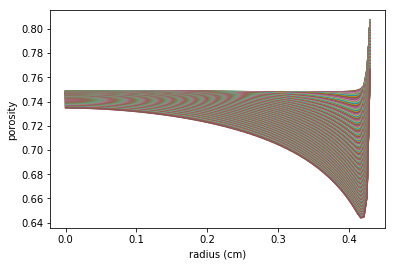

In [28]:
for step in range(1,total_steps+1):
    
    print
    print ('TIME STEP:', step)
    print ('Anode')
    
    
    
    coldA = time_step(coldA,cprevA,tstep,propC,zincp)
    zincp = properties(zincp,coldA,tstep)
    rate_eq = rate_equation(coldA,tstep,zincp)
    vol_chg = volume_change(coldA,tstep,zincp,init_vol)
    init_vol = vol_chg
    j = transfer(coldA)
    
    
    
    junk,right_flux = fluxes(coldA)
    propC[0] = epc
    propC[3] = coldA[2,NJ-1]
    propC[4] = coldA[1,NJ-1]
    propC[6] = right_flux
    #print(zincp[6,:])
    propC = cathode(propC,tstep)
    cprevA = coldA
    
     
    #if step ==10 or step == 75 or step == 120 or step == 170 or step == 200 or step == 250 or step == 276:
    #if step < 11:   
    plt.plot(xs,coldA[3,:],label = int(step*10/60))
        #plt.plot(xs,zincp[6,:],label = int(step*10/60))
    plt.ylabel('porosity')
    plt.xlabel('radius (cm)')
        #plt.legend(loc='lower left',shadow=True, ncol=2)
        #savefig('porosity', dpi=1200)
    
    
    if (zincp[5,:] <= 0).any()==True:
        break    

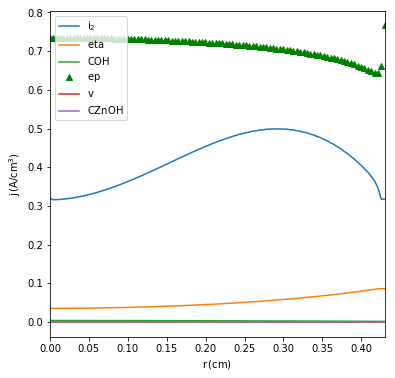

In [29]:
# ===========
# PLOT RESULTS
# ===========

fig,ax = plt.subplots(1,1,figsize=(6, 6))

params = {'mathtext.default': 'regular' }
rcParams.update(params)


xs = linspace(0,ra,NJ)
c1 = j
c2 = coldA[1,:]
c3 = coldA[2,:]
c4 = coldA[3,:]
c5 = coldA[4,:]
c6 = coldA[5,:]
ax.plot(xs,c1)
ax.plot(xs,c2)
ax.plot(xs,c3)
ax.plot(xs,c4,'g^')
ax.plot(xs,c5)
ax.plot(xs,c6)
ax.legend(['$i_{2}$','$eta$','$COH$','$ep$','$v$','$CZnOH$'],loc='upper left')
ax.set_ylabel('$j\/(A/cm^{3})$')
ax.set_xlabel('$r\/(cm)$')
ax.set_xlim(0, ra)
savefig('All_V.png', dpi=300)
plt.show()

close('all')


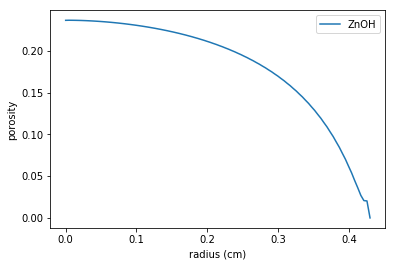

0.9300914506257905

In [30]:
plt.plot(xs,zincp[5,:],label='ZnOH')
#plt.plot(xs,zincp[4,:],label='OHe')
plt.xlabel('radius (cm)')
plt.ylabel('porosity')
plt.legend()
#savefig('ep.png', dpi=1200)
plt.show()